In [1]:
import torch
import numpy as np
from torch import nn
import tensorly as tl
from tqdm import tqdm
import matplotlib.pyplot
from torch.optim import Adam
from torch.utils.data import DataLoader

In [2]:
from tensor_layer import *

In [3]:
tl.set_backend('pytorch')

In [4]:
train_set = MOA_set("train_X.npy", "train_Y.npy")
val_set = MOA_set("val_X.npy", "val_Y.npy")
test_set = MOA_set("testing_X.npy")

In [5]:
len(train_set), len(val_set), len(test_set)

(17860, 5954, 3982)

In [6]:
BATCH_SIZE = 32

In [7]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class TensorNet(nn.Module): 
    
    def __init__(self, order, input_dim, tensor_dim, output_dim, rank_tucker=5):
        super(TensorNet, self).__init__()
        self.tensor = NeuralTensorLayer(
            order, input_dim, tensor_dim, rank_tucker=rank_tucker
        )
        self.bn = nn.BatchNorm1d(tensor_dim)
        self.l = nn.Linear(tensor_dim, output_dim)
        self.s = nn.Sigmoid()
        
    def forward(self, x):
        return(self.s(self.l(self.bn(self.tensor(x)))))
    
    def predict(self, loader, train=True, verbose=False):
        Y_hat = []
        ld = tqdm(loader) if verbose else loader
        for a in ld:
            d = a[0] if train else a
            c_y_hat = self.forward(d).cpu().data.numpy()
            Y_hat.append(c_y_hat)
        return(np.concatenate(Y_hat))
    
    def fit(self, loader, loss, optimizer, n_iter, val_loader, metrics):
        history = {a: [] for a in metrics}
        history["loss"] = []
        for i in tqdm(np.arange(n_iter)):
            mean_loss = 0
            self.train()
            for i,(batch_X, batch_Y) in enumerate(loader):
                optimizer.zero_grad()
                Y_hat = self.forward(batch_X)
                loss_val = loss(Y_hat, batch_Y)
                loss_val.backward()
                optimizer.step()
                mean_loss += loss_val.cpu().data.numpy()
            history["loss"].append(mean_loss/i)
            self.eval()
            val_Y_hat = self.predict(val_loader)
            val_Y = np.concatenate([a[1].cpu().data.numpy() for a in val_loader])
            for m in metrics:
                history[m].append(metrics[m](val_Y, val_Y_hat))
        return(history)

In [10]:
model = TensorNet(2, 879, 300, 206)

In [11]:
loss = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [12]:
def frobenius(Y, Y_hat):
    return(np.sqrt(np.sum((Y-Y_hat)**2)))

In [13]:
history = model.fit(train_loader, loss, optimizer, 5, val_loader, {"F": frobenius})

AssertionError: Torch not compiled with CUDA enabled

In [13]:
history

{'F': [62.900517, 62.80128, 62.952988, 61.615765, 61.69992],
 'loss': [0.10858990903776873,
  0.020391361257161504,
  0.020339781884104013,
  0.020256580664746223,
  0.020293479015897144]}

In [16]:
axes

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f22341a1410>,
      dtype=object)

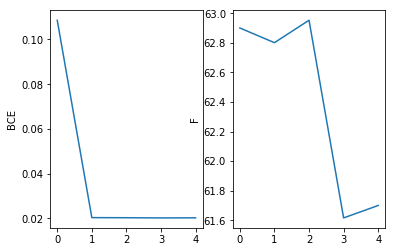

In [21]:
fig, axes = plt.subplots(1,2)
axes[0].plot(history["loss"])
axes[1].plot(history["F"])
axes[0].set_ylabel("BCE")
axes[1].set_ylabel("F")
plt.show()